# Phip-Seq Python fold analysis

Here, we are trying to replicate the analysis done in `PhiP_seq_analysis_CIS.Rmd`.
Notice this file obfuscates some of the computation behind some helper function that can be found in `phip_data.py` - this was mostly for me to get an idea about what operations we can start packaging into more robust code.

Generally, the code here could serve as the discussion point for more robust code that will help us deal with and do interersting stuff to the data obtained from phip-seq experiments.

## input data
This is a good point of discussion, but moving forward I think we might have an easier time splitting the data from experiments into three tables: The counts table, the peptide metadata, and sample metadata. But I'm open to suggestions.

In [3]:
from phip_data import *
%matplotlib inline

# Set some constants
DD = "../empirical_data"
COUNTS = "sample_peptide_counts.csv"
PMETA= "peptide_metadata.csv"
SMETA= "sample_metadata.csv"
OUTDIR="./fold_analysis_output"

# the following two could (and should) be extracted from sample metadata
# once we determine a standardized format.
# Beads only sample is the mock IP
beads_only_sample = "35"
# The library_control is the pure abundance of phage in library sample
library_control_sample = "37.input"
corr_thresh = 0.9

In [4]:
out_dir = os.path.join(DD,OUTDIR)
raw_counts = os.path.join(DD,COUNTS)
peptide_metadata = os.path.join(DD,PMETA)
sample_metadata = os.path.join(DD,SMETA)
# TODO extract this from sample metadata.

if not os.path.exists(out_dir): os.mkdir(out_dir) 

# TODO just make a function which returns all raw_counts and metadata 
# after error checking the input
raw_counts = pd.read_csv(raw_counts, header=0, index_col=0)
peptide_metadata = pd.read_csv(peptide_metadata, header=0, index_col=0)
sample_metadata = pd.read_csv(sample_metadata, header=0, index_col=0)

print(f"Raw counts DataFrame: \n\n {raw_counts.head()} \n\n")
print(f"Peptide metadata DataFrame: \n\n {peptide_metadata.head()} \n\n")
print(f"Sample metadata DataFrame: \n\n{sample_metadata.head()} \n\n")

Raw counts DataFrame: 

       1.1  1.2  10.1  10.2  11.1  11.2  12.1  12.2  13.1  13.2  ...  5.1  5.2  \
id                                                              ...             
1     102   12    61    74     7   132     4   380    79    51  ...   19  337   
10    106  229   183   352    81   777     0   122   310   112  ...  498  598   
195   106  229   183   352    81   777     0   122   310   112  ...  498  598   
100    54   63    73    15     8    97     6   213    60    94  ...   38    8   
1001    0    0    10    75     0     9     0     0     0     0  ...    2    0   

      6.1  6.2  7.1  7.2  8.1  8.2  9.1  9.2  
id                                            
1      53   13  210  484   70   77  189  484  
10     24  103  232  128   71  206  128  312  
195    24  103  232  128   71  206  128  312  
100    12   94   55  287   55   83  113  198  
1001    1    2   22    8    3    7    4   12  

[5 rows x 73 columns] 


Peptide metadata DataFrame: 

                  Viru

**NOTE** It's good to discuss what the best specific data format we should expect is.

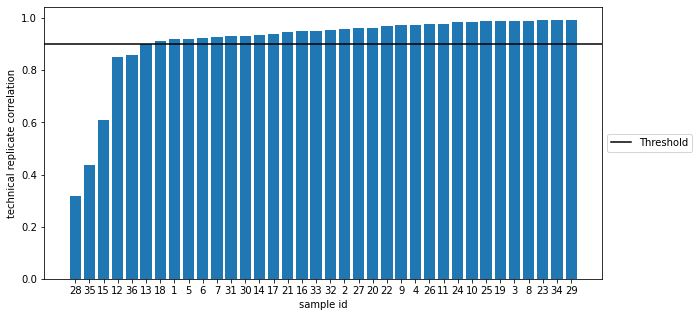

In [5]:
# Make sure we have the same indexing going on here.
assert(set(raw_counts.index) == set(peptide_metadata.index))

# Now we need to look at correlation between the technical replicates,
# first determine the replicates.
technical_rep_1, technical_rep_2 = extract_sample_info(raw_counts)

# given the technical rep
pruned_counts, correlations, samples = prune_non_correlated_replicate_samples(
    raw_counts, 
    technical_rep_1,
    technical_rep_2,
    corr_thresh = 0.9)

fig, ax = plt.subplots(figsize=(13, 10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

correlations = [c[0] for c in correlations]
samples = [x for _,x in sorted(zip(correlations,samples))]
ax.bar(samples, sorted(correlations))
ax.axhline(y=corr_thresh, color="black", label = "Threshold")
ax.set_ylabel(f"technical replicate correlation")
ax.set_xlabel(f"sample id")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(10,5)
#fig.savefig(os.path.join(out_dir,"technical_replicates_correlation.pdf"))
plt.show()

## Problem
The standardized_enrichment computation below produces *slightly* different results (on the order of 10e-2 per entry) from that in `PhiP_seq_analysis_CIS.Rmd`. The R code used in that analysis looks like this:

```
#read in file with summed counts. **Note: a pseudocount of 10 has been applied across the entire dataset.
count_data_pseudo <- read_csv("../empirical_data/cstoddar_allSamps_redundant_annotated_MODpseudo_summed_reps.csv")

#sum all the columns except first four
col_sums=apply((count_data_pseudo[,-c(1:4)]), 2, sum)

#divide each count by the column sum to determine frequency
freq=cbind(count_data_pseudo[,1:4],(sweep((count_data_pseudo[,-c(1:4)]), 2, col_sums, "/")))

#divide frequency by normalized input to determine fold-enrichment (note that we manually changed the code to specify input data column)
enrichment=cbind(count_data_pseudo[,1:4],(sweep(freq[,-c(1:4)], 1, freq$X37.input, "/")))

#subtract out background enrichment; here, the beads_only_sum is also subtracted from the Input and Beads_only_sum. However, we have already used these values to establish enrichment so we are fine to proceed with this analysis. Manually copied one replicate (for now) of beads-only samples into code

standardized_enrichment=cbind(count_data_pseudo[,1:4],(sweep(enrichment[,-c(1:4)], 1, enrichment$X35, "-")))
#print(standardized_enrichment)

write.csv(standardized_enrichment,"20200325_standardized_enrichment_summed_reps.csv")
```

Hopeing someone can help tell me why my code produces slightly different results.

In [6]:
# get the standardized enrichment of strains across samples.
frequencies = pruned_counts.truediv(pruned_counts.sum(axis=0), axis=1)
enrichment = frequencies.truediv(frequencies[library_control_sample], axis=0)
standardized_enrichment = enrichment.subtract(enrichment[beads_only_sample], axis=0)

### Results. 
Still looks like we get a few interesting results. 

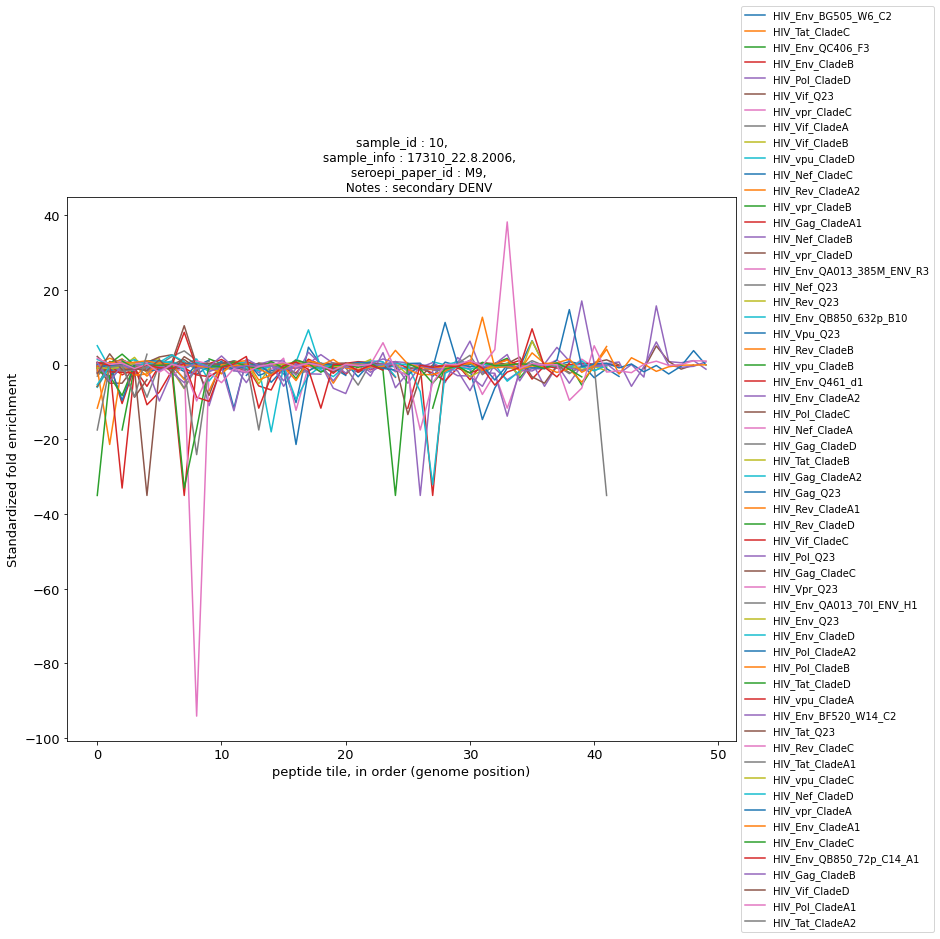

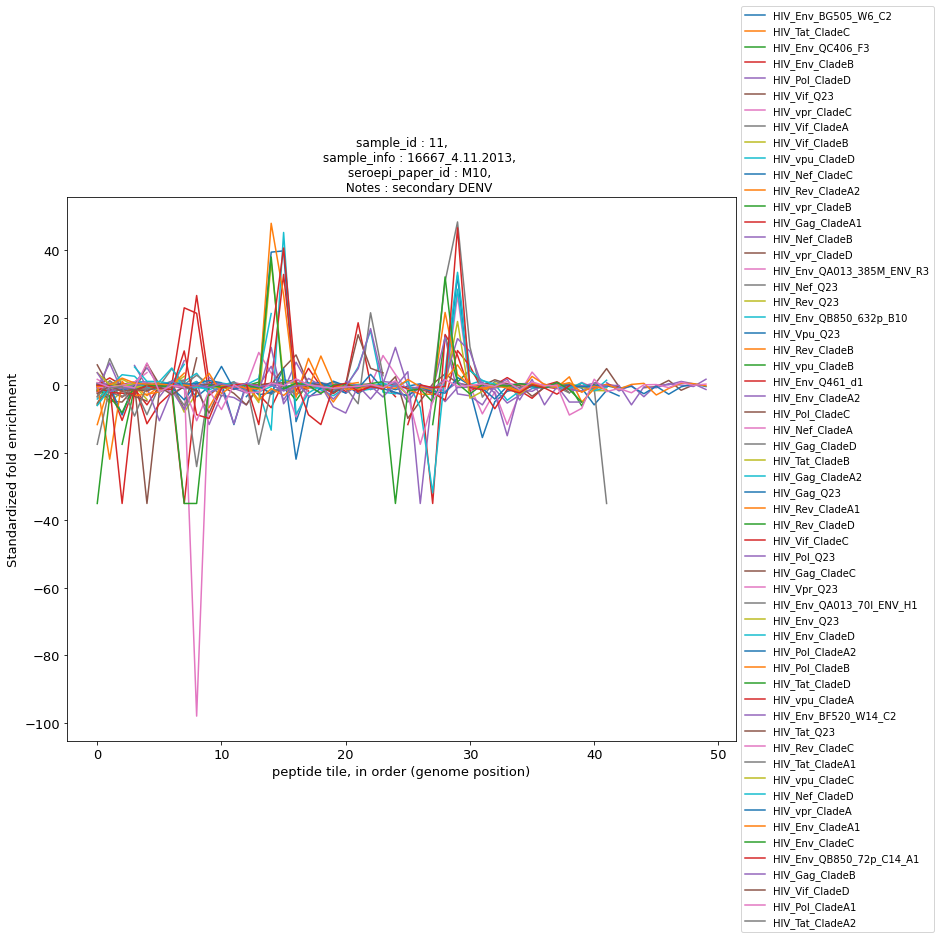

In [7]:
# choose a pattern for virus to compare.
# you could also define this manually
strain_pattern = "HIV.+"
#strain_pattern = "DENV.+"
#strain_pattern = "ZIKV.+"

# samples to look at, this could also be done 
# by querying the sample metadata or listed manually
samples = standardized_enrichment.columns[2:4]

all_strains = set(peptide_metadata["Virus_Strain"])
selected_strains = [re.match(strain_pattern,f"{strain}")[0] 
    for strain in all_strains 
    if re.match(strain_pattern,f"{strain}") != None]

for sample in samples:
    if sample == library_control_sample: continue
    
    fig, ax = plt.subplots(figsize=(12, 10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    
    for strain in selected_strains:
        strain_index = peptide_metadata[peptide_metadata["Virus_Strain"] == strain].index
        ax.plot(list(range(len(strain_index))),
                standardized_enrichment[sample][strain_index],
                label = strain)
    
    # TODO : we should make these strings, or the the 
    # header for counts data integers ... ?
    sample = int(sample)
    
    sample_info = sample_metadata["sample_info"][sample]
    seroepi_paper_id = sample_metadata["seroepi_paper_id"][sample]
    notes = sample_metadata["Notes"][sample]
    ax.set_title(
        f"sample_id : {sample},\n \
        sample_info : {sample_info},\n \
        seroepi_paper_id : {seroepi_paper_id},\n \
        Notes : {notes}")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(f"Standardized fold enrichment")
    ax.set_xlabel(f"peptide tile, in order (genome position)")
    #fig.savefig(f"../Attic/fold_enrichment_{sample}.pdf")
    plt.show()